# Классификация

## 1. Выбор начальных условий

In [ ]:
! pip install scikit-learn --upgrade


In [ ]:
import numpy as np

from sklearn.metrics import (
    accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score,
    RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import (
    StandardScaler, TargetEncoder,
    OneHotEncoder, LabelEncoder,
    label_binarize
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


### a. Набор данных

Датасет https://www.kaggle.com/datasets/mojtaba142/hotel-booking/data

Данный датасет содержит 119390 наблюдений для двух типов отелей: City Hotel и Resort Hotel. Каждое наблюдение представляет собой бронирование в одном из отелей в период с 1 июля 2015 года по 31 августа 2017 года, включая как бронирования, которые действительно состоялись, так и те, которые были отменены.

В датасете содержатся данные о различных аспектах бронирований, таких как дата бронирования, продолжительность пребывания, количество гостей и другие параметры, связанные с бронированием. В целях конфиденциальности, все элементы данных, касающиеся идентификации отелей или клиентов, были удалены. Вместо этого в датасет были добавлены четыре искусственно созданных столбца: 'name', 'email', 'phone number' и 'credit_card'.

Данный датасет был изначально представлен в статье "Hotel Booking Demand Datasets" авторами Нуну Антонио, Аной Алмейдой и Луисом Нунесом для журнала Data in Brief в феврале 2019 года.

Этот датасет может быть полезен для анализа спроса на отельные услуги, прогнозирования вероятности отмены бронирования и других задач в области анализа данных и машинного обучения.

In [ ]:
from google.colab import files

# Загрузка kaggle.json
uploaded = files.upload()

# Перемещение токена в нужную директорию
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:

!pip install -q kaggle

# Проверка установки
!kaggle datasets list

ref                                                                    title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset                    Customer Shopping (Latest Trends) Dataset        76KB  2024-11-23 15:26:12          13864        267  1.0              
hopesb/student-depression-dataset                                      Student Depression Dataset.                     454KB  2024-11-22 17:56:03          10597        143  1.0              
jeleeladekunlefijabi/ship-fuel-consumption-and-co2-emissions-analysis  Ship Fuel Consumption & CO2 Emissions Analysis   30KB  2024-12-15 13:36:56            566         24  1.0              
denkuznetz/taxi-price-prediction             

Загрузка датасета

In [ ]:
import kagglehub

path = kagglehub.dataset_download("mojtaba142/hotel-booking")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mojtaba142/hotel-booking/versions/1


In [ ]:
import os

# Выводим список файлов в директории
print("Файлы в датасете:")
for file_name in os.listdir(path):
    print(file_name)

Файлы в датасете:
hotel_booking.csv


In [ ]:
import pandas as pd

file_path = os.path.join(path, "hotel_booking.csv")

# Загружаем датасет
data = pd.read_csv(file_path)

data.head(15)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.00,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.00,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.00,0,1,Check-Out,2015-07-03,Jasmine Fletcher,JFletcher43@xfinity.com,190-271-6743,************9263
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,Transient,107.00,0,0,Check-Out,2015-07-03,Dylan Rangel,Rangel.Dylan@comcast.net,420-332-5209,************6994
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,Transient,103.00,0,1,Check-Out,2015-07-03,William Velez,Velez_William@mail.com,286-669-4333,************8729
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,Transient,82.00,0,1,Canceled,2015-05-06,Steven Murphy,Steven.Murphy54@aol.com,341-726-5787,************3639
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,Transient,105.50,0,0,Canceled,2015-04-22,Michael Moore,MichaelMoore81@outlook.com,316-648-6176,************9190


### b. Метрики качества

В качестве метри для задачи классификации будем использовать:
 - Accuracy = (TP + TN) / (TP + TN + FP + FN);
 - F1-score = 2 * (presicion * recall) / (presicion + recall).

Данные метрики подойдут, поскольку в данном датасете представлена задача бинарной классификации со сбалансированными данными

## 2. Создание бейзлайна и оценка качества





Fake Features

In [ ]:
fake_features = ['name', 'email', 'phone-number', 'credit_card']
prepared_dt = data.drop(columns=fake_features)

In [ ]:
prepared_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  int64  
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  int64  
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
nan_cols = {}
for col in prepared_dt:
    if any(prepared_dt[col].isna()):
        nan_cols[col] = [sum(prepared_dt[col].isna()) / len(prepared_dt) * 100]
nan_cols = pd.DataFrame({key : [f"{val[0]:.3f}%"] for key, val in nan_cols.items()})

In [ ]:
# nan_cols

Столбцы Agent и Company содержать ID, которые в целом не несут особой пользы, к тому же в Company 94% пропущенных значений, поэтому данные два столбца можно польностью удалить.

Столбцы Children и Country содержат небольшое количество пропусков, Contry "восстановить" сложновато, поэтому удалим незначительное количество записей, в которых есть пропуски.

In [ ]:
prepared_dt = prepared_dt.drop(columns=["agent", "company"])
prepared_dt = prepared_dt.dropna(axis=0)
prepared_dt = prepared_dt.reset_index(drop=True)

In [ ]:
prepared_dt.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,1,0,342,2015,5,27,1,0,0,2,...,0,2,2,3,0,0,2,0.0,0,0
1,1,0,737,2015,5,27,1,0,0,2,...,0,2,2,4,0,0,2,0.0,0,0
2,1,0,7,2015,5,27,1,0,1,1,...,0,0,2,0,0,0,2,75.0,0,0
3,1,0,13,2015,5,27,1,0,1,1,...,0,0,0,0,0,0,2,75.0,0,0
4,1,0,14,2015,5,27,1,0,2,2,...,0,0,0,0,0,0,2,98.0,0,1


In [ ]:
prepared_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119386 entries, 0 to 119385
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119386 non-null  int64  
 1   is_canceled                     119386 non-null  int64  
 2   lead_time                       119386 non-null  int64  
 3   arrival_date_year               119386 non-null  int64  
 4   arrival_date_month              119386 non-null  int64  
 5   arrival_date_week_number        119386 non-null  int64  
 6   arrival_date_day_of_month       119386 non-null  int64  
 7   stays_in_weekend_nights         119386 non-null  int64  
 8   stays_in_week_nights            119386 non-null  int64  
 9   adults                          119386 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119386 non-null  int64  
 12  meal            

kNN:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Функция для оценки результатов
def print_evaluation(y_test, y_pred):
    print("Accuracy score:")
    print(accuracy_score(y_test, y_pred))
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Подготовка данных
X = prepared_dt.drop(['is_canceled', 'reservation_status', 'reservation_status_date'], axis=1)  # Убираем ненужные признаки
y = prepared_dt['is_canceled']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель KNN
model_1 = KNeighborsClassifier(n_neighbors=5)
model_1.fit(X_train, y_train)

y_pred = model_1.predict(X_test)

print_evaluation(y_test, y_pred)

Accuracy score:
0.7941201105620236

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     14973
           1       0.75      0.68      0.71      8905

    accuracy                           0.79     23878
   macro avg       0.78      0.77      0.78     23878
weighted avg       0.79      0.79      0.79     23878



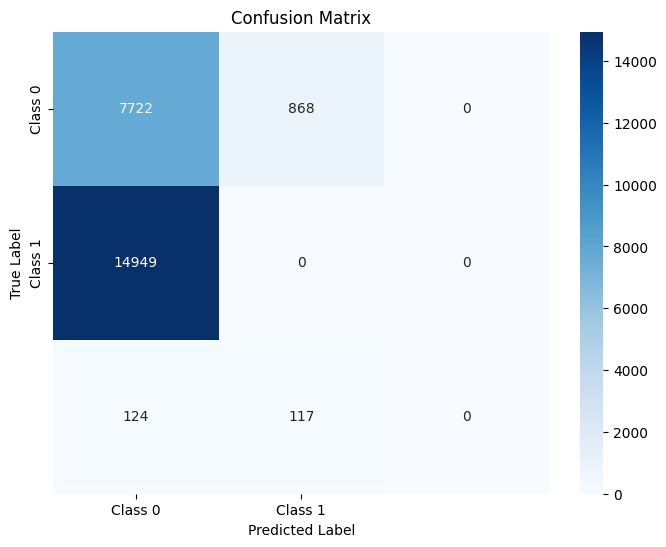

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = ["Class 0", "Class 1"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## b. Логистическая и линейная регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Функция для оценки регрессии
def print_evaluation2(y_test, y_pred):
    print("MSE score")
    print(mean_squared_error(y_test, y_pred))
    print("Accuracy score")
    print(accuracy_score(y_test, y_pred))

In [ ]:
# Модель 2: Логистическая регрессия
model_2 = LogisticRegression(random_state=42, max_iter=1000)
model_2.fit(X_train, y_train)

y_pred2 = model_2.predict(X_test)
print("Logistic Regression Evaluation:")
print_evaluation2(y_test, y_pred2)

Logistic Regression Evaluation:
MSE score
0.21877879219365107
Accuracy score
0.781221207806349


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Модель 3: Линейная регрессия
model_3 = LinearRegression()
model_3.fit(X_train, y_train)

y_pred3 = model_3.predict(X_test)
print("MSE score")
print(mean_squared_error(y_test, y_pred3))

MSE score
0.15033144104084403


### c. Решающее дерево

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_4 = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5
)
model_4.fit(X_train, y_train)

y_pred4 = model_4.predict(X_test)
print_evaluation(y_test, y_pred4)


Accuracy score:
0.7922774101683558

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85     14973
           1       0.84      0.55      0.66      8905

    accuracy                           0.79     23878
   macro avg       0.81      0.74      0.76     23878
weighted avg       0.80      0.79      0.78     23878



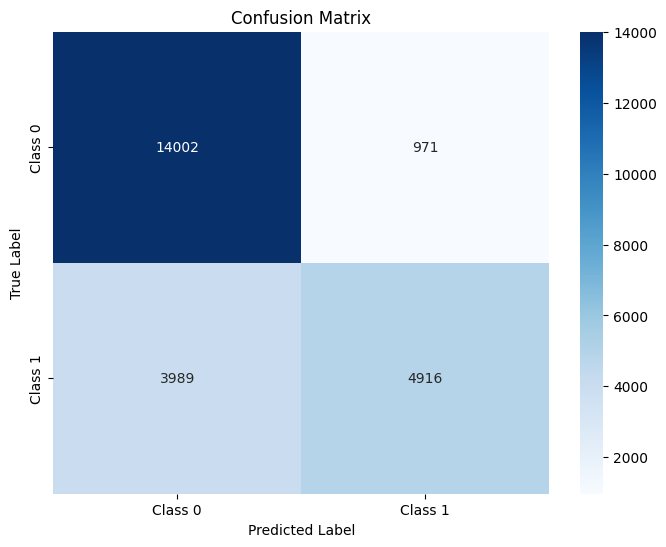

In [ ]:
cm = confusion_matrix(y_test, y_pred4)
labels = ["Class 0", "Class 1"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## d. Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
model_5 = RandomForestClassifier(n_estimators=100, random_state=42)
model_5.fit(X_train,y_train)

y_pred5 = model_5.predict(X_test)
print_evaluation(y_test, y_pred5)

Accuracy score:
0.8919088700896223

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     14973
           1       0.89      0.81      0.85      8905

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.88     23878
weighted avg       0.89      0.89      0.89     23878



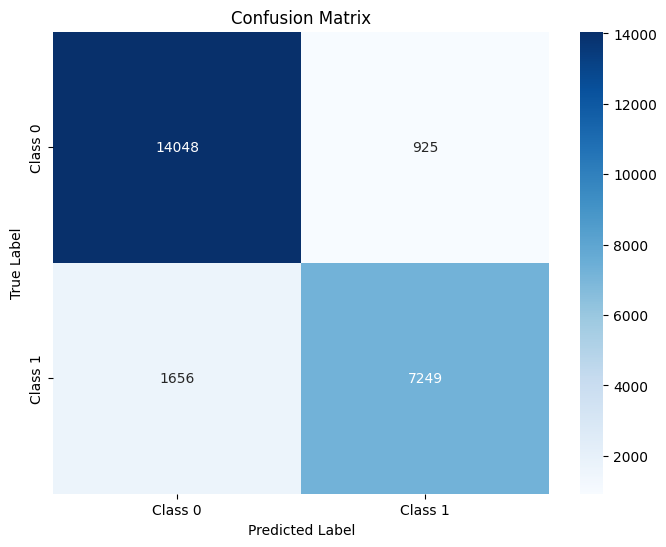

In [ ]:
cm = confusion_matrix(y_test, y_pred5)
labels = ["Class 0", "Class 1"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### e. Градиентный бустинг

In [ ]:
model_6 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model_6.fit(X_train,y_train)

y_pred6 = model_6.predict(X_test)
print_evaluation(y_test, y_pred6)

Accuracy score:
0.8411508501549544

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     14973
           1       0.83      0.72      0.77      8905

    accuracy                           0.84     23878
   macro avg       0.84      0.82      0.83     23878
weighted avg       0.84      0.84      0.84     23878



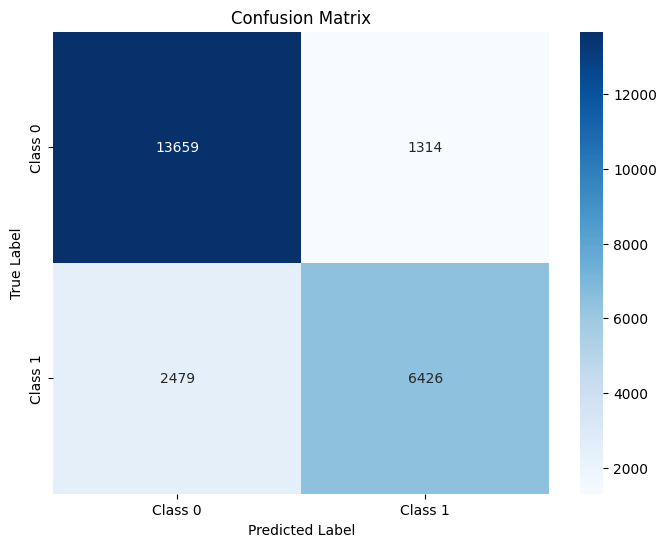

In [ ]:
cm = confusion_matrix(y_test, y_pred6)
labels = ["Class 0", "Class 1"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3. Улучшение бейзлайна

Выполним препроцессинг данных, чтобы улучшить бейзлайн

In [ ]:
# prepared_dt = prepared_dt.drop(['reservation_status', 'reservation_status_date'], axis=1)

# Преобразование категориальных признаков
# Используем LabelEncoder для столбцов, где есть категориальные данные
label_encoders = {}
for column in prepared_dt.select_dtypes(include='object').columns:
    le = LabelEncoder()
    prepared_dt[column] = le.fit_transform(prepared_dt[column])
    label_encoders[column] = le

X = prepared_dt.drop('is_canceled', axis=1)
y = prepared_dt['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
prepared_dt

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,1,0,342,2015,5,27,1,0,0,2,...,0,2,2,3,0,0,2,0.00,0,0
1,1,0,737,2015,5,27,1,0,0,2,...,0,2,2,4,0,0,2,0.00,0,0
2,1,0,7,2015,5,27,1,0,1,1,...,0,0,2,0,0,0,2,75.00,0,0
3,1,0,13,2015,5,27,1,0,1,1,...,0,0,0,0,0,0,2,75.00,0,0
4,1,0,14,2015,5,27,1,0,2,2,...,0,0,0,0,0,0,2,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119381,0,0,23,2017,1,35,30,2,5,2,...,0,0,0,0,0,0,2,96.14,0,0
119382,0,0,102,2017,1,35,31,2,5,3,...,0,4,4,0,0,0,2,225.43,0,2
119383,0,0,34,2017,1,35,31,2,5,2,...,0,3,3,0,0,0,2,157.71,0,4
119384,0,0,109,2017,1,35,31,2,5,2,...,0,0,0,0,0,0,2,104.40,0,0


Исследуем датасет и визуализируем некоторую информацию

In [ ]:
prepared_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119386 entries, 0 to 119385
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119386 non-null  int64  
 1   is_canceled                     119386 non-null  int64  
 2   lead_time                       119386 non-null  int64  
 3   arrival_date_year               119386 non-null  int64  
 4   arrival_date_month              119386 non-null  int64  
 5   arrival_date_week_number        119386 non-null  int64  
 6   arrival_date_day_of_month       119386 non-null  int64  
 7   stays_in_weekend_nights         119386 non-null  int64  
 8   stays_in_week_nights            119386 non-null  int64  
 9   adults                          119386 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119386 non-null  int64  
 12  meal            

In [ ]:
prepared_dt.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


<ipython-input-93-47080b4361a1>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=prepared_dt["country"]);


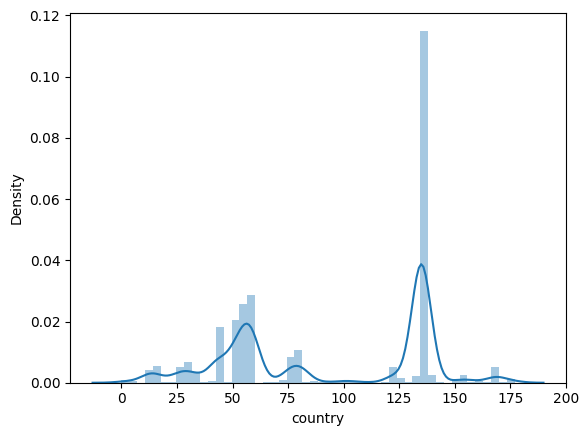

In [ ]:
sns.distplot(a=prepared_dt["country"]);

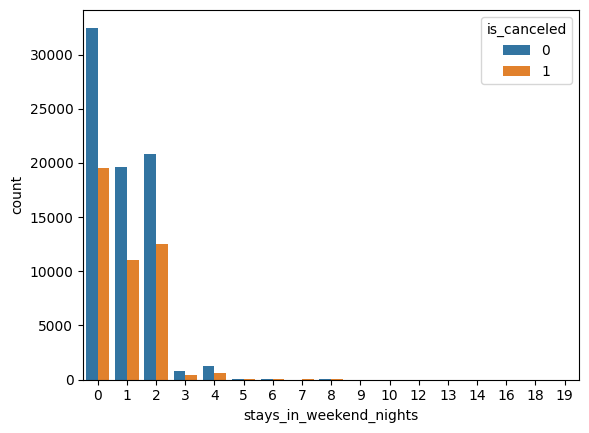

In [ ]:
sns.countplot(x='stays_in_weekend_nights', hue='is_canceled', data=prepared_dt);

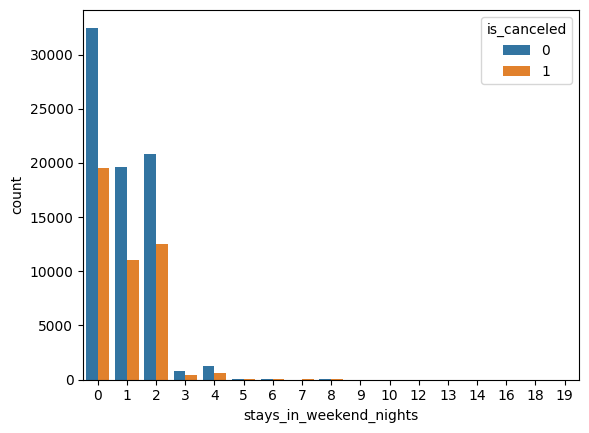

In [ ]:
sns.countplot(x='stays_in_weekend_nights', hue='is_canceled', data=prepared_dt);

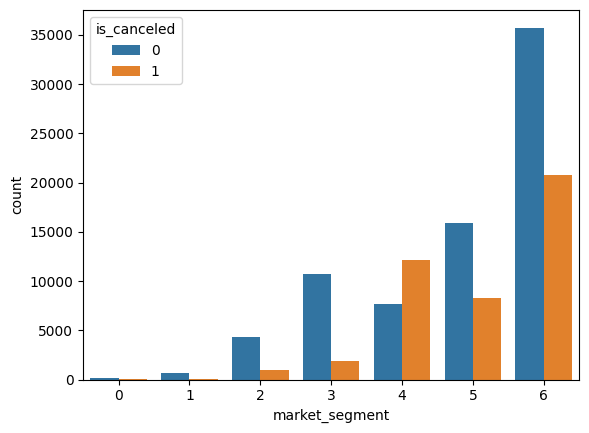

In [ ]:
sns.countplot(x='market_segment', hue='is_canceled', data=prepared_dt);

<ipython-input-99-d5ea5e656af4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=prepared_dt["assigned_room_type"]);


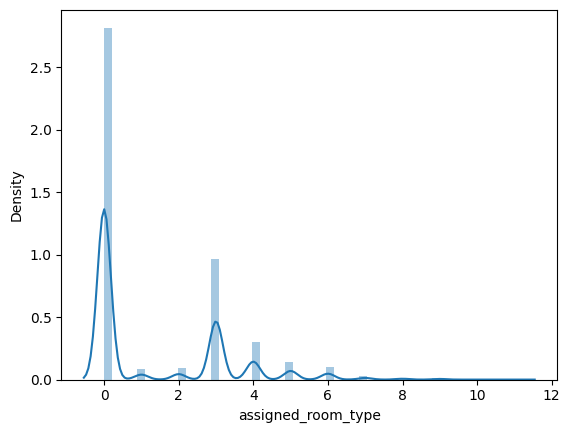

In [ ]:
sns.distplot(a=prepared_dt["assigned_room_type"]);

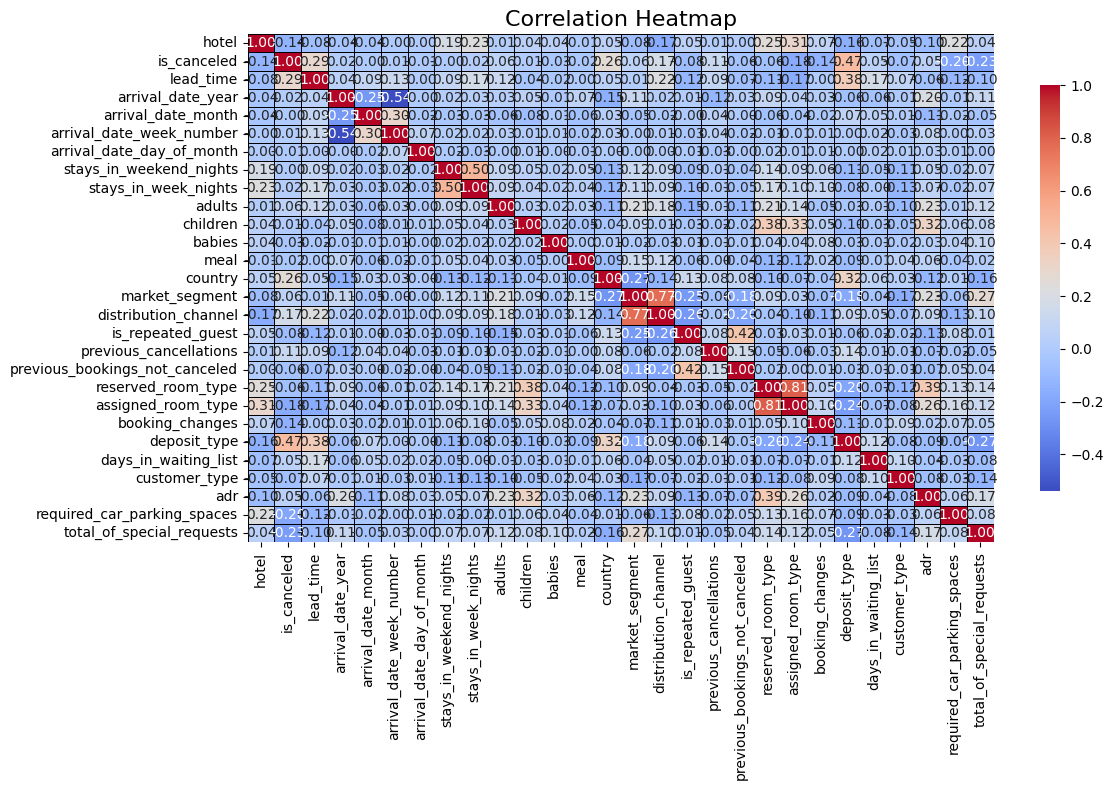

In [ ]:

plt.figure(figsize=(12, 8))
sns.heatmap(prepared_dt.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()

plt.show()

In [ ]:
print(len(prepared_dt.arrival_date_year.unique()))
print(len(prepared_dt.arrival_date_month.unique()))
print(len(prepared_dt.arrival_date_week_number.unique()))

3
12
53


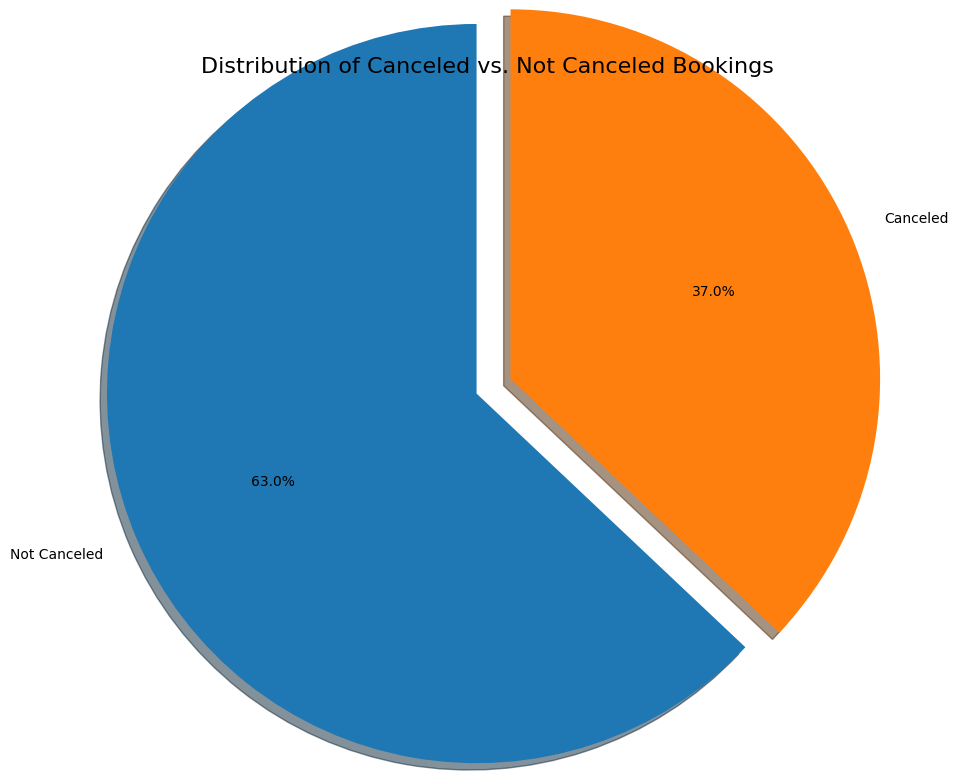

In [ ]:
# Группировка данных по целевой переменной 'is_canceled'
r = prepared_dt['is_canceled'].value_counts()

# Создание круговой диаграммы
plt.figure(figsize=(8, 8)) 
plt.pie(r, explode=[0.05, 0.1], labels=['Not Canceled', 'Canceled'],
        radius=1.5, autopct='%1.1f%%', shadow=True, startangle=90)

plt.title('Distribution of Canceled vs. Not Canceled Bookings', fontsize=16)

plt.show()

После визуализации данных можно сделать несколько выводов:

Класс Not Canceled составляет 63% от набора данных, в то время как класс Canceled — 37%. Классы не сбалансированы, что может повлиять на точность модели. Возможно, потребуется применить методы балансировки классов, такие как oversampling, undersampling или использование взвешенных классов.

В наборах данных присутствуют пропущенные значения в нескольких столбцах. Пропущенные данные были удалены на этапе препроцессинга, однако в реальных приложениях необходимо либо заполнять их (например, с помощью медианы или моды), либо учитывать при обучении моделей.

Признаки, такие как hotel, meal, customer_type, reservation_status, являются категориальными и их необходимо закодировать для использования в моделях. Для категориальных признаков, содержащих несколько категорий, рекомендуется использовать метод one-hot encoding. Для бинарных категорий можно использовать Label Encoding.

In [ ]:
data2 = pd.read_csv(file_path)

Fake Features and missing values

In [ ]:
fake_features = ['name', 'email', 'phone-number', 'credit_card']
pr_data2 = data2.drop(columns=fake_features)

nan_cols = {}
for col in pr_data2:
    if any(pr_data2[col].isna()):
        nan_cols[col] = [sum(pr_data2[col].isna()) / len(pr_data2) * 100]
nan_cols = pd.DataFrame({key : [f"{val[0]:.3f}%"] for key, val in nan_cols.items()})

pr_data2 = pr_data2.drop(columns=["agent", "company"])
pr_data2 = pr_data2.dropna(axis=0)
pr_data2 = pr_data2.reset_index(drop=True)

In [ ]:
def get_date_parser(frag_idx):
    def date_to_int(date):
        return int(date.split("-")[frag_idx])
    return date_to_int

In [ ]:
status_year = pr_data2["reservation_status_date"].apply(get_date_parser(0)).rename("reservation_status_year")
status_month = pr_data2["reservation_status_date"].apply(get_date_parser(1)).rename("reservation_status_month")
status_day = pr_data2["reservation_status_date"].apply(get_date_parser(2)).rename("reservation_status_day")
pr_data2 = pd.concat([pr_data2, status_year, status_month, status_day], axis=1)
pr_data2 = pr_data2.drop(columns=["reservation_status_date"])

In [ ]:
pr_data2.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_year,reservation_status_month,reservation_status_day
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,0,Transient,0.0,0,0,Check-Out,2015,7,1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,0,Transient,0.0,0,0,Check-Out,2015,7,1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0,Transient,75.0,0,0,Check-Out,2015,7,2
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,0,Transient,75.0,0,0,Check-Out,2015,7,2
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,0,Transient,98.0,0,1,Check-Out,2015,7,3


Split & Encoding

In [ ]:
class CustomEncoder:
    def __init__(self, col_to_ohe: list, col_to_te: list):
        self.ohe = OneHotEncoder(sparse_output=False)
        self.te = TargetEncoder()
        self.__to_ohe = col_to_ohe
        self.__to_te = col_to_te
        self.__to_map = "arrival_date_month"
        self.__months = {"January": 1, "February": 2, "March": 3, "April": 4,
                         "May": 5, "June": 6, "July": 7, "August": 8,
                         "September": 9, "October": 10, "November": 11, "December": 12}

    @staticmethod
    def tf_to_dt(data, encoder, columns):
        transformed = encoder.transform(data[columns])
        out_columns = encoder.get_feature_names_out(columns)
        return pd.DataFrame(transformed, columns=out_columns, index=data.index)

    def fit(self, x_dt, y_dt):
        self.ohe.fit(x_dt[self.__to_ohe])
        self.te.fit(x_dt[self.__to_te], y_dt)
        return self

    def transform(self, data):
        ohe_dt = self.tf_to_dt(data, self.ohe, self.__to_ohe)
        te_dt = self.tf_to_dt(data, self.te, self.__to_te)

        new_data = data.drop(columns=[*self.__to_ohe, *self.__to_te])
        new_data = pd.concat([new_data, ohe_dt, te_dt], axis=1)
        new_data[self.__to_map] = new_data[self.__to_map].map(self.__months)
        return new_data

    def fit_transform(self, x_dt, y_dt):
        self.fit(x_dt, y_dt)
        return self.transform(x_dt)

In [ ]:
features = pr_data2.drop(columns=["reservation_status"])
target = pr_data2["reservation_status"]

In [ ]:
cat_features = features.select_dtypes(exclude=['int', 'float'])
cat_features.columns

Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type'],
      dtype='object')

In [ ]:
def prepare_cat(categories, max_count=20):
    result = f"[{', '.join(categories[:20])}]"
    if len(categories) > max_count:
        return f"{result[:-1]}, ...]"
    return result

In [ ]:
for col in cat_features:
    categories = cat_features[col].unique()
    print(f"{col} ({len(categories)}):")
    print(prepare_cat(categories), end="\n"*2)

hotel (2):
[Resort Hotel, City Hotel]

arrival_date_month (12):
[July, August, September, October, November, December, January, February, March, April, May, June]

meal (5):
[BB, FB, HB, SC, Undefined]

country (177):
[PRT, GBR, USA, ESP, IRL, FRA, ROU, NOR, OMN, ARG, POL, DEU, BEL, CHE, CN, GRC, ITA, NLD, DNK, RUS, ...]

market_segment (7):
[Direct, Corporate, Online TA, Offline TA/TO, Complementary, Groups, Aviation]

distribution_channel (5):
[Direct, Corporate, TA/TO, Undefined, GDS]

reserved_room_type (10):
[C, A, D, E, G, F, H, L, B, P]

assigned_room_type (12):
[C, A, D, E, G, F, I, B, H, L, K, P]

deposit_type (3):
[No Deposit, Refundable, Non Refund]

customer_type (4):
[Transient, Contract, Transient-Party, Group]



Рассмотрим признаки с "Undefined"

In [ ]:
cat_features["meal"].value_counts()

,count
meal,
BB,91863
HB,14434
SC,10638
Undefined,1165
FB,798


In [ ]:
cat_features["distribution_channel"].value_counts()

,count
distribution_channel,
TA/TO,97730
Direct,14483
Corporate,6491
GDS,193
Undefined,1


В случае "meal", "Undefined" можно выделить в отдельную категорию. В случае же "distribution_channel" - ради одной записи оно того не стоит, поэтому удалим данный объект из рассмотрения

In [ ]:
mask = pr_data2["distribution_channel"] == "Undefined"
pr_data2 = pr_data2.drop(pr_data2[mask].index).reset_index(drop=True)

In [ ]:
features = pr_data2.drop(columns=["reservation_status"])
target = pr_data2["reservation_status"]

Теперь закодируем категориальные признаки следующим образом:

arrival_date_month: map (в соответствии с порядковыми номерами месяцев)

hotel, meal, deposit_type, customer_type: OHE

other: TE

In [ ]:
to_ohe = ["hotel", "meal", "deposit_type", "customer_type"]
to_te = list(cat_features.drop(columns=[*to_ohe, "arrival_date_month"]).columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                    stratify=target, random_state=2024)
print(f"Train: {len(X_train)}")
print(f"Test:  {len(X_test)}")

Train: 95117
Test:  23780


In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
le.classes_

array(['Canceled', 'Check-Out', 'No-Show'], dtype=object)

In [ ]:
y_train

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
encoder = CustomEncoder(to_ohe, to_te)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [ ]:
X_train

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,market_segment_2,distribution_channel_0,distribution_channel_1,distribution_channel_2,reserved_room_type_0,reserved_room_type_1,reserved_room_type_2,assigned_room_type_0,assigned_room_type_1,assigned_room_type_2
5216,0,191,2016,4,17,22,1,2,2,0.0,...,0.009983,0.401794,0.589132,0.009074,0.382547,0.607250,0.010204,0.435668,0.554705,0.009627
115236,0,171,2017,7,27,6,1,3,2,0.0,...,0.010274,0.401794,0.589132,0.009074,0.382547,0.607250,0.010204,0.435668,0.554705,0.009627
86245,0,58,2016,4,15,5,0,3,2,0.0,...,0.010274,0.401794,0.589132,0.009074,0.307756,0.682651,0.009593,0.242347,0.747326,0.010326
111886,0,12,2017,5,21,23,0,1,1,0.0,...,0.010274,0.401794,0.589132,0.009074,0.382547,0.607250,0.010204,0.435668,0.554705,0.009627
67188,1,134,2017,5,18,6,1,1,2,0.0,...,0.010274,0.401794,0.589132,0.009074,0.382547,0.607250,0.010204,0.435668,0.554705,0.009627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117845,0,103,2017,8,33,17,0,2,2,0.0,...,0.010274,0.401794,0.589132,0.009074,0.382547,0.607250,0.010204,0.435668,0.554705,0.009627
37574,0,1,2017,7,27,7,0,1,2,0.0,...,0.010274,0.401794,0.589132,0.009074,0.382547,0.607250,0.010204,0.435668,0.554705,0.009627
39206,0,65,2017,8,33,18,2,5,2,0.0,...,0.010274,0.401794,0.589132,0.009074,0.382547,0.607250,0.010204,0.435668,0.554705,0.009627
63524,1,17,2017,2,9,26,2,1,1,0.0,...,0.003653,0.401794,0.589132,0.009074,0.307756,0.682651,0.009593,0.242347,0.747326,0.010326


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95117 entries, 5216 to 79331
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     95117 non-null  int64  
 1   lead_time                       95117 non-null  int64  
 2   arrival_date_year               95117 non-null  int64  
 3   arrival_date_month              95117 non-null  int64  
 4   arrival_date_week_number        95117 non-null  int64  
 5   arrival_date_day_of_month       95117 non-null  int64  
 6   stays_in_weekend_nights         95117 non-null  int64  
 7   stays_in_week_nights            95117 non-null  int64  
 8   adults                          95117 non-null  int64  
 9   children                        95117 non-null  float64
 10  babies                          95117 non-null  int64  
 11  is_repeated_guest               95117 non-null  int64  
 12  previous_cancellations          95

Наконец, нормализуем признаки, т.к. метрические классификаторы чувствительны к "масштабу" признаков

In [ ]:
ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns, index=X_test.index)

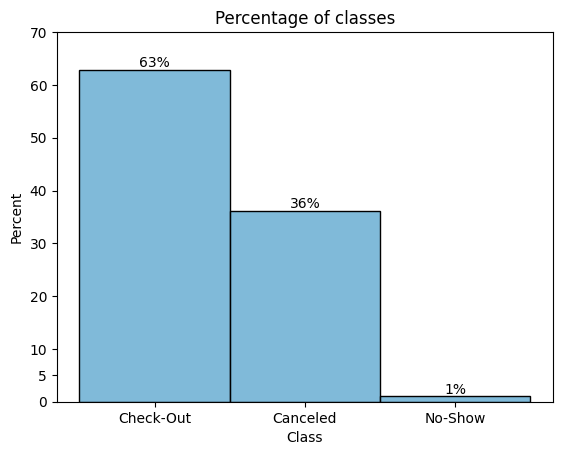

In [ ]:
sns.set_palette("icefire")
ax = sns.histplot(target, bins=len(target.unique()), discrete=True,
                  stat="percent")
ax.set_xticks(np.arange(len(target.unique())))
ax.set_yticks([*ax.get_yticks(), 5])
for p in ax.patches:
    text = f"{round(p.get_height())}%"
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), text,
            fontsize=10, ha='center', va='bottom')
ax.set_xlabel("Class")
plt.title("Percentage of classes")
pass

### Теперь данные готовы для применения модели машинного обучения

### KNN


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5,metric='minkowski',p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print_evaluation(y_test, y_pred)

Accuracy score:
0.9777964676198486

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8590
           1       0.98      1.00      0.99     14949
           2       0.57      0.15      0.24       241

    accuracy                           0.98     23780
   macro avg       0.84      0.71      0.73     23780
weighted avg       0.97      0.98      0.98     23780



### Логистическая и линейная регрессия

In [ ]:
model_2 = LogisticRegression(max_iter = 500000)
model_2.fit(X_train,y_train)

y_pred2 = model_2.predict(X_test)
print_evaluation2(y_test, y_pred2)

MSE score
0.03936080740117746
Accuracy score
0.9901597981497057


In [ ]:
model_3 = LinearRegression()
model_3.fit(X_train,y_train)

y_pred3 = model_3.predict(X_test)
print("MSE score")
print(mean_squared_error(y_test, y_pred3))

MSE score
0.03797995431228701


### Решающее дерево

In [ ]:
model_4 = DecisionTreeClassifier(criterion="entropy",random_state=420)
model_4.fit(X_train, y_train)

y_pred4 = model_4.predict(X_test)
print_evaluation(y_test, y_pred4)

Accuracy score:
0.9886038687973087

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8590
           1       1.00      1.00      1.00     14949
           2       0.43      0.37      0.40       241

    accuracy                           0.99     23780
   macro avg       0.80      0.79      0.79     23780
weighted avg       0.99      0.99      0.99     23780



### Случайный лес

In [ ]:
model_5 = RandomForestClassifier(criterion='gini', bootstrap=True, random_state=420)
model_5.fit(X_train, y_train)

y_pred5 = model_5.predict(X_test)
print_evaluation(y_test, y_pred5)

Accuracy score:
0.992094196804037

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8590
           1       1.00      1.00      1.00     14949
           2       0.87      0.26      0.40       241

    accuracy                           0.99     23780
   macro avg       0.95      0.75      0.80     23780
weighted avg       0.99      0.99      0.99     23780



### Градиентный бустинг

In [ ]:
model_6 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model_6.fit(X_train,y_train)

y_pred6 = model_6.predict(X_test)
print_evaluation(y_test, y_pred6)

Accuracy score:
0.9907905803195963

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8590
           1       1.00      1.00      1.00     14949
           2       0.74      0.14      0.24       241

    accuracy                           0.99     23780
   macro avg       0.91      0.71      0.74     23780
weighted avg       0.99      0.99      0.99     23780



## Вывод

### Как видно из сравнения результатов, все модели показали лучшие точности на улучшенным бейзлайне, а это значит, что препроцессинг оказался удачным

# 4. Имплементация алгоритмов машинного обучения

In [ ]:
data4_1 = pd.read_csv(file_path)
data4_1.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [ ]:
fake_features = ['name', 'email', 'phone-number', 'credit_card']
prepared_dt_4_1 = data4_1.drop(columns=fake_features)

In [ ]:
nan_cols = {}
for col in prepared_dt_4_1:
    if any(prepared_dt_4_1[col].isna()):
        nan_cols[col] = [sum(prepared_dt_4_1[col].isna()) / len(prepared_dt_4_1) * 100]
nan_cols = pd.DataFrame({key : [f"{val[0]:.3f}%"] for key, val in nan_cols.items()})

In [ ]:
prepared_dt_4_1 = prepared_dt_4_1.drop(columns=["agent", "company"])
prepared_dt_4_1 = prepared_dt_4_1.dropna(axis=0)
prepared_dt_4_1 = prepared_dt_4_1.reset_index(drop=True)

In [ ]:
prepared_dt_4_1.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03


## KNN

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Преобразуем категориальные признаки в числовой формат с помощью LabelEncoder
encoder = LabelEncoder()
categorical_cols = prepared_dt_4_1.select_dtypes(include=['object']).columns  # определяем категориальные столбцы

for col in categorical_cols:
    prepared_dt_4_1[col] = encoder.fit_transform(prepared_dt_4_1[col])

# Убираем строки с пропусками
prepared_dt_4_1 = prepared_dt_4_1.dropna()

X = prepared_dt_4_1.drop(['is_canceled', 'reservation_status', 'reservation_status_date'], axis=1)
y = prepared_dt_4_1['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [ ]:
# Функция KNN
def knn_predict(X_train, y_train, X_test, k=5):
    predictions = []
    for test_point in X_test:
        # Вычисляем расстояние до всех точек обучающего набора
        distances = np.linalg.norm(X_train - test_point, axis=1)

        # Получаем индексы k ближайших соседей
        nearest_neighbor_ids = distances.argsort()[:k]

        # Получаем метки классов этих соседей
        nearest_labels = y_train[nearest_neighbor_ids]

        # Предсказываем класс (наиболее часто встречающийся среди соседей)
        unique, counts = np.unique(nearest_labels, return_counts=True)
        majority_class = unique[np.argmax(counts)]

        predictions.append(majority_class)

    return np.array(predictions)

def knn_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

k = 5  
y_pred = knn_predict(X_train_np, y_train_np, X_test_np, k)

accuracy = knn_accuracy(y_test_np, y_pred)
print(f"Точность собственного KNN: {accuracy:.3f}")


Точность собственного KNN: 0.792


In [ ]:
print_evaluation(y_test_np, y_pred)

Accuracy score:
0.791757779646762

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84     14851
           1       0.75      0.67      0.71      8929

    accuracy                           0.79     23780
   macro avg       0.78      0.77      0.77     23780
weighted avg       0.79      0.79      0.79     23780



## Логистическая и линейная регрессия

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        # Градиентный спуск
        for _ in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            predictions = 1 / (1 + np.exp(-model))

            # Вычисляем градиенты
            dw = (1 / m) * np.dot(X.T, (predictions - y))
            db = (1 / m) * np.sum(predictions - y)

            # Обновляем веса
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        model = np.dot(X, self.weights) + self.bias
        predictions = 1 / (1 + np.exp(-model))
        return np.round(predictions)

lr_model = LogisticRegression(learning_rate=0.1, n_iterations=1000)
lr_model.fit(X_train_np, y_train_np)

y_pred_lr = lr_model.predict(X_test_np)

accuracy_lr = np.mean(y_test_np == y_pred_lr)
print(f"Точность модели логистической регрессии: {accuracy_lr:.3f}")

<ipython-input-54-3c98aec23bad>:16: RuntimeWarning: overflow encountered in exp
  predictions = 1 / (1 + np.exp(-model))


Точность модели логистической регрессии: 0.418


<ipython-input-54-3c98aec23bad>:28: RuntimeWarning: overflow encountered in exp
  predictions = 1 / (1 + np.exp(-model))


In [ ]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        for _ in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            predictions = model

            dw = (1 / m) * np.dot(X.T, (predictions - y))
            db = (1 / m) * np.sum(predictions - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

lin_reg_model = LinearRegression(learning_rate=0.1, n_iterations=1000)
lin_reg_model.fit(X_train_np, y_train_np)

y_pred_lin_reg = lin_reg_model.predict(X_test_np)

mse = np.mean((y_test_np - y_pred_lin_reg) ** 2)
print(f"Среднеквадратичная ошибка модели линейной регрессии: {mse:.3f}")

Среднеквадратичная ошибка модели линейной регрессии: nan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Решающее дерево

In [ ]:
import numpy as np
import pandas as pd

# Функция для вычисления энтропии
def entropy(y):
    class_counts = np.bincount(y)
    probabilities = class_counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Добавляем небольшое значение для предотвращения логарифма от нуля

# Функция для разбиения данных на два подмножества
def split_dataset(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[right_mask], y[right_mask]
    return X_left, y_left, X_right, y_right

# Функция для нахождения наилучшего разбиения
def best_split(X, y):
    best_gain = 0
    best_feature = None
    best_threshold = None
    n_features = X.shape[1]
    current_entropy = entropy(y)

    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])

        for threshold in thresholds:
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)
            if len(y_left) == 0 or len(y_right) == 0:
                continue

            # Вычисляем информацию после разделения
            left_entropy = entropy(y_left)
            right_entropy = entropy(y_right)
            weighted_entropy = (len(y_left) / len(y)) * left_entropy + (len(y_right) / len(y)) * right_entropy

            # Вычисляем прирост информации
            info_gain = current_entropy - weighted_entropy

            if info_gain > best_gain:
                best_gain = info_gain
                best_feature = feature_index
                best_threshold = threshold

    return best_feature, best_threshold

# Класс для решающего дерева
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1:
            return np.unique(y)[0]  # Листовое узло, возвращаем класс

        if self.max_depth is not None and depth >= self.max_depth:
            return np.bincount(y).argmax()  # Если достигли максимальной глубины, возвращаем наиболее частый класс

        best_feature, best_threshold = best_split(X, y)

        if best_feature is None:
            return np.bincount(y).argmax()  # Если не найдено разбиение, возвращаем наиболее частый класс

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        return {
            'feature_index': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _predict_sample(self, sample, tree):
        if isinstance(tree, dict):  
            if sample[tree['feature_index']] <= tree['threshold']:
                return self._predict_sample(sample, tree['left'])
            else:
                return self._predict_sample(sample, tree['right'])
        else:
            return tree  


In [ ]:

clf = DecisionTree()
clf.fit(X_train_np, y_train_np)

y_pred = clf.predict(X_test_np)

accuracy = np.mean(y_pred == y_test_np)
print(f"Точность решающего дерева: {accuracy:.3f}")


Точность решающего дерева: 0.852


In [ ]:
print_evaluation(y_test_np, y_pred)

Accuracy score:
0.8520185029436501

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     14851
           1       0.80      0.81      0.80      8929

    accuracy                           0.85     23780
   macro avg       0.84      0.84      0.84     23780
weighted avg       0.85      0.85      0.85     23780



 ## Случайный лес

In [ ]:
# Класс для случайного леса
class RandomForest:
    def __init__(self, n_trees=100, max_depth=None, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            sample_indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample, y_sample = X[sample_indices], y[sample_indices]

            # Выбираем случайный поднабор признаков
            n_features = X.shape[1]
            if self.max_features is None:
                max_features = n_features
            else:
                max_features = self.max_features
            feature_indices = np.random.choice(n_features, size=max_features, replace=False)

            tree = DecisionTree(max_depth=self.max_depth)
            X_sample_reduced = X_sample[:, feature_indices]
            tree.fit(X_sample_reduced, y_sample)
            self.trees.append((tree, feature_indices))  # Сохраняем дерево и индексы использованных признаков

    def predict(self, X):
        tree_preds = np.array([tree.predict(X[:, feature_indices]) for tree, feature_indices in self.trees])
        # Голосуем за наиболее частый класс
        return np.array([np.bincount(tree_pred).argmax() for tree_pred in tree_preds.T])



In [ ]:
rf = RandomForest(n_trees=10, max_depth=3, max_features=2)
rf.fit(X_train_np, y_train_np)

y_pred = rf.predict(X_test_np)

accuracy = np.mean(y_pred == y_test_np)
print(f"Точность: {accuracy:.3f}")

Точность: 0.625


In [ ]:
print_evaluation(y_test_np, y_pred)

Accuracy score:
0.6342724978973928

Classification report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     14851
           1       1.00      0.03      0.05      8929

    accuracy                           0.63     23780
   macro avg       0.82      0.51      0.41     23780
weighted avg       0.77      0.63      0.50     23780



## Градиентный бустинг

In [ ]:
from sklearn.tree import DecisionTreeClassifier

class GradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X, y):
        y_pred = np.full_like(y, np.mean(y, dtype=np.float64), dtype=np.float64)

        for _ in range(self.n_estimators):
            # Вычисляем остатки
            residual = y - y_pred

            # Строим дерево классификации на остатках
            model = DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=5)
            model.fit(X, residual > 0)  # Преобразуем остатки в метки классов
            self.models.append(model)

            # Обновляем предсказания
            y_pred += self.learning_rate * model.predict_proba(X)[:, 1]

    def predict(self, X):
        # Начальные предсказания
        pred = np.zeros(X.shape[0], dtype=np.float64)
        for model in self.models:
            pred += self.learning_rate * model.predict_proba(X)[:, 1]
        return (pred > 0.5).astype(int)  # Преобразуем в метки классов


In [ ]:
print(f"Тип данных в y_train_np: {y_train_np.dtype}")
print(f"Уникальные значения в y_train_np: {np.unique(y_train_np)}")


Тип данных в y_train_np: int64
Уникальные значения в y_train_np: [0 1]


In [ ]:
y_train_np = np.where(y_train_np > 0, 1, 0)
y_test_np = np.where(y_test_np > 0, 1, 0)

gb_model = GradientBoosting(n_estimators=100, learning_rate=0.1)
gb_model.fit(X_train_np, y_train_np)

y_pred = gb_model.predict(X_test_np)

accuracy = np.mean(y_test_np == y_pred)
print(f"Точность модели градиентного бустинга: {accuracy:.3f}")

Точность модели градиентного бустинга: 0.325


### Вывод: как можно убедиться по результатам метрик , что моя собственная имплементация алгоритмов обучения показывает их значения, не хуже чем при использовании моделей из sklearn, а иногда такая имплементация бывает более наглядной

### Теперь с предобработкой

In [ ]:
data3 = pd.read_csv(file_path)
data3.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [ ]:
fake_features = ['name', 'email', 'phone-number', 'credit_card']
pr_data3 = data3.drop(columns=fake_features)

nan_cols = {}
for col in pr_data3:
    if any(pr_data3[col].isna()):
        nan_cols[col] = [sum(pr_data3[col].isna()) / len(pr_data3) * 100]
nan_cols = pd.DataFrame({key : [f"{val[0]:.3f}%"] for key, val in nan_cols.items()})

pr_data3 = pr_data3.drop(columns=["agent", "company"])
pr_data3 = pr_data3.dropna(axis=0)
pr_data3 = pr_data3.reset_index(drop=True)

def get_date_parser(frag_idx):
    def date_to_int(date):
        return int(date.split("-")[frag_idx])
    return date_to_int

status_year = pr_data3["reservation_status_date"].apply(get_date_parser(0)).rename("reservation_status_year")
status_month = pr_data3["reservation_status_date"].apply(get_date_parser(1)).rename("reservation_status_month")
status_day = pr_data3["reservation_status_date"].apply(get_date_parser(2)).rename("reservation_status_day")
pr_data3 = pd.concat([pr_data3, status_year, status_month, status_day], axis=1)
pr_data3 = pr_data3.drop(columns=["reservation_status_date"])

In [ ]:
class CustomEncoder:
    def __init__(self, col_to_ohe: list, col_to_te: list):
        self.ohe = OneHotEncoder(sparse_output=False)
        self.te = TargetEncoder()
        self.__to_ohe = col_to_ohe
        self.__to_te = col_to_te
        self.__to_map = "arrival_date_month"
        self.__months = {"January": 1, "February": 2, "March": 3, "April": 4,
                         "May": 5, "June": 6, "July": 7, "August": 8,
                         "September": 9, "October": 10, "November": 11, "December": 12}

    @staticmethod
    def tf_to_dt(data, encoder, columns):
        transformed = encoder.transform(data[columns])
        out_columns = encoder.get_feature_names_out(columns)
        return pd.DataFrame(transformed, columns=out_columns, index=data.index)

    def fit(self, x_dt, y_dt):
        self.ohe.fit(x_dt[self.__to_ohe])
        self.te.fit(x_dt[self.__to_te], y_dt)
        return self

    def transform(self, data):
        ohe_dt = self.tf_to_dt(data, self.ohe, self.__to_ohe)
        te_dt = self.tf_to_dt(data, self.te, self.__to_te)

        new_data = data.drop(columns=[*self.__to_ohe, *self.__to_te])
        new_data = pd.concat([new_data, ohe_dt, te_dt], axis=1)
        new_data[self.__to_map] = new_data[self.__to_map].map(self.__months)
        return new_data

    def fit_transform(self, x_dt, y_dt):
        self.fit(x_dt, y_dt)
        return self.transform(x_dt)

fake_features = ['name', 'email', 'phone-number', 'credit_card']
pr_data3 = data3.drop(columns=fake_features)

nan_cols = {}
for col in pr_data3:
    if any(pr_data3[col].isna()):
        nan_cols[col] = [sum(pr_data3[col].isna()) / len(pr_data3) * 100]
nan_cols = pd.DataFrame({key : [f"{val[0]:.3f}%"] for key, val in nan_cols.items()})

pr_data3 = pr_data3.drop(columns=["agent", "company"])
pr_data3 = pr_data3.dropna(axis=0)
pr_data3 = pr_data3.reset_index(drop=True)

def get_date_parser(frag_idx):
    def date_to_int(date):
        return int(date.split("-")[frag_idx])
    return date_to_int

status_year = pr_data3["reservation_status_date"].apply(get_date_parser(0)).rename("reservation_status_year")
status_month = pr_data3["reservation_status_date"].apply(get_date_parser(1)).rename("reservation_status_month")
status_day = pr_data3["reservation_status_date"].apply(get_date_parser(2)).rename("reservation_status_day")
pr_data3 = pd.concat([pr_data3, status_year, status_month, status_day], axis=1)
pr_data3 = pr_data3.drop(columns=["reservation_status_date"])

features = pr_data3.drop(columns=["reservation_status"])
target = pr_data3["reservation_status"]

cat_features = features.select_dtypes(exclude=['int', 'float'])
cat_features.columns

def prepare_cat(categories, max_count=20):
    result = f"[{', '.join(categories[:20])}]"
    if len(categories) > max_count:
        return f"{result[:-1]}, ...]"
    return result

for col in cat_features:
    categories = cat_features[col].unique()
    print(f"{col} ({len(categories)}):")
    print(prepare_cat(categories), end="\n"*2)

mask = pr_data3["distribution_channel"] == "Undefined"
pr_data3 = pr_data3.drop(pr_data3[mask].index).reset_index(drop=True)

to_ohe = ["hotel", "meal", "deposit_type", "customer_type"]
to_te = list(cat_features.drop(columns=[*to_ohe, "arrival_date_month"]).columns)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                    stratify=target, random_state=2024)

encoder = CustomEncoder(to_ohe, to_te)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(ss.transform(X_test), columns=X_test.columns, index=X_test.index)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

hotel (2):
[Resort Hotel, City Hotel]

arrival_date_month (12):
[July, August, September, October, November, December, January, February, March, April, May, June]

meal (5):
[BB, FB, HB, SC, Undefined]

country (177):
[PRT, GBR, USA, ESP, IRL, FRA, ROU, NOR, OMN, ARG, POL, DEU, BEL, CHE, CN, GRC, ITA, NLD, DNK, RUS, ...]

market_segment (7):
[Direct, Corporate, Online TA, Offline TA/TO, Complementary, Groups, Aviation]

distribution_channel (5):
[Direct, Corporate, TA/TO, Undefined, GDS]

reserved_room_type (10):
[C, A, D, E, G, F, H, L, B, P]

assigned_room_type (12):
[C, A, D, E, G, F, I, B, H, L, K, P]

deposit_type (3):
[No Deposit, Refundable, Non Refund]

customer_type (4):
[Transient, Contract, Transient-Party, Group]

(95118, 51) (23780, 51)
(95118,) (23780,)


## KNN


In [ ]:
import numpy as np

def knn_predict(X_train, y_train, X_test, k=5):
    predictions = []
    for test_point in X_test:
        # Вычисляем расстояние до всех точек обучающего набора
        distances = np.linalg.norm(X_train - test_point, axis=1)

        # Получаем индексы k ближайших соседей
        nearest_neighbor_ids = distances.argsort()[:k]

        # Получаем метки классов этих соседей
        nearest_labels = y_train[nearest_neighbor_ids]

        # Предсказываем класс (наиболее часто встречающийся среди соседей)
        unique, counts = np.unique(nearest_labels, return_counts=True)
        majority_class = unique[np.argmax(counts)]

        predictions.append(majority_class)

    return np.array(predictions)

def knn_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

encoder = CustomEncoder(col_to_ohe=to_ohe, col_to_te=to_te)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# Преобразование в numpy.ndarray
X_train_np = X_train_encoded.to_numpy()
X_test_np = X_test_encoded.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

k = 5  # количество соседей
y_pred = knn_predict(X_train_np, y_train_np, X_test_np, k)

accuracy = knn_accuracy(y_test_np, y_pred)
print(f"Точность собственного KNN: {accuracy:.3f}")



Точность собственного KNN: 0.887


In [ ]:
print(accuracy_score(y_test, y_pred))

0.8865433137089992


## Логистическая и линейная регрессия

In [ ]:
features = pr_data3.drop(columns=["reservation_status"])
target = pr_data3["reservation_status"]


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                    stratify=target, random_state=2024)

In [ ]:

lr_model = LogisticRegression(learning_rate=0.1, n_iterations=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

accuracy_lr = np.mean(y_test == y_pred)
print(f"Точность модели логистической регрессии: {accuracy_lr:.3f}")

Точность модели логистической регрессии: 0.988


In [ ]:
print_evaluation(y_test, y_pred)

Accuracy score:
0.9878048780487805

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8590
           1       1.00      1.00      1.00     14949
           2       0.00      0.00      0.00       241

    accuracy                           0.99     23780
   macro avg       0.66      0.66      0.66     23780
weighted avg       0.98      0.99      0.98     23780



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        for _ in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            predictions = model

            dw = (1 / m) * np.dot(X.T, (predictions - y))
            db = (1 / m) * np.sum(predictions - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [ ]:
lin_reg_model = LinearRegression(learning_rate=0.1, n_iterations=1000)
lin_reg_model.fit(X_train, y_train)

y_pred_lin_reg = lin_reg_model.predict(X_test)

mse = np.mean((y_test - y_pred_lin_reg) ** 2)
print(f"Среднеквадратичная ошибка модели линейной регрессии: {mse:.3f}")

Среднеквадратичная ошибка модели линейной регрессии: 0.038


In [ ]:
print_evaluation2(y_test, y_pred)

MSE score
0.04058031959629941
Accuracy score
0.9878048780487805


## Решающее дерево

In [ ]:
clf = DecisionTree()
clf.fit(X_train_np, y_train_np)

y_pred = clf.predict(X_test_np)

accuracy = np.mean(y_pred == y_test_np)
print(f"Точность решающего дерева: {accuracy:.3f}")

Точность решающего дерева: 0.852


## Случайный лес

In [ ]:
class RandomForest:
    def __init__(self, n_trees=100, max_depth=None, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.array(X)
        y = y.to_numpy() if isinstance(y, pd.Series) else np.array(y)

        for _ in range(self.n_trees):
            sample_indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample, y_sample = X[sample_indices], y[sample_indices]

            # Выбираем случайный поднабор признаков
            n_features = X.shape[1]
            max_features = self.max_features if self.max_features else n_features
            feature_indices = np.random.choice(n_features, size=max_features, replace=False)

            # Строим дерево на случайной подвыборке и подмножестве признаков
            tree = DecisionTree(max_depth=self.max_depth)
            X_sample_reduced = X_sample[:, feature_indices]
            tree.fit(X_sample_reduced, y_sample)

            # Сохраняем дерево и индексы признаков
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else np.array(X)

        tree_preds = np.array([tree.predict(X[:, feature_indices]) for tree, feature_indices in self.trees])

        # Используем голосование для определения итогового предсказания
        return np.array([np.bincount(tree_pred).argmax() for tree_pred in tree_preds.T])


In [ ]:
rf = RandomForest(n_trees=10, max_depth=3, max_features=2)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Точность: {accuracy:.3f}")


Точность: 0.652


In [ ]:
print_evaluation(y_test, y_pred)

Accuracy score:
0.6520605550883095

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.12      8590
           1       0.64      1.00      0.78     14949
           2       0.00      0.00      0.00       241

    accuracy                           0.65     23780
   macro avg       0.55      0.35      0.30     23780
weighted avg       0.77      0.65      0.54     23780



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Градиентный бустинг

In [ ]:
gb_model = GradientBoosting(n_estimators=200, learning_rate=0.1)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)

accuracy = np.mean(y_test == y_pred)
print(f"Точность модели градиентного бустинга: {accuracy:.3f}")

Точность модели градиентного бустинга: 0.542


### Вывод: В рамках задачи классификации я реализовал несколько моделей машинного обучения, включая градиентный бустинг, случайный лес, KNN, решающее дерево, а также логистическую и линейную регрессию. Результаты, полученные с помощью этих моделей, оказались приемлемыми по сравнению с результатами, полученным с использованием готовых реализаций из библиотеки scikit-learn. Это подтверждает, что мои реализации могут быть использованы на небольших и средних по сложности датасетах.

### Тем не менее, для более сложных задач и крупных данных предпочтительнее использовать оптимизированные решения из sklearn, так как они обладают более высокой производительностью и могут автоматически подстраиваться под различные особенности данных. В моей реализации есть потенциал для повышения точности, например, путем настройки гиперпараметров, улучшения алгоритмов оптимизации или добавления дополнительных методов регуляризации.